# XGBoost stock prediction

In [47]:
import torch
import numpy as np
import pandas as pd
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import math
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score 


In [48]:
df = pd.read_csv('../data/upload_DJIA_table.csv', parse_dates=['Date'], index_col='Date')
df = df[['Close']]
df = df.sort_index()

training_data_len = math.ceil(len(df) * .8)

train_data = df[:training_data_len].iloc[:,:1]
test_data = df[training_data_len:].iloc[:,:1]
print(train_data.shape, test_data.shape)

(1592, 1) (397, 1)


In [49]:
bert_embeddings = np.load('../bert_embeddings.npy')

bert_train = bert_embeddings[:training_data_len]
bert_test = bert_embeddings[training_data_len:]
print(bert_train.shape, bert_test.shape)

(1592, 1, 768) (397, 1, 768)


In [50]:
fingpt_sentiments = np.load('../fingpt_sentiment.npy').astype('float32') 

fingpt_sentiments = fingpt_sentiments.reshape(-1, 1)
sentiments_train = fingpt_sentiments[:training_data_len]
sentiments_test = fingpt_sentiments[training_data_len:]

print(sentiments_train.shape, sentiments_test.shape)

(1592, 1) (397, 1)


In [51]:
dataset_train = train_data.values
dataset_train = np.reshape(dataset_train, (-1,1))

dataset_test = test_data.values
dataset_test = np.reshape(dataset_test, (-1,1))

dataset_test.shape, dataset_train.shape

((397, 1), (1592, 1))

In [52]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

scaled_train = scaler.fit_transform(dataset_train)
print(scaled_train[:5])

scaled_test = scaler.fit_transform(dataset_test)
print(*scaled_test[:5])

[[0.45640217]
 [0.46062803]
 [0.44832069]
 [0.43868547]
 [0.44598557]]
[0.84454818] [0.86667668] [0.82659367] [0.80725839] [0.70619221]


In [53]:
scaled_train.shape

(1592, 1)

In [54]:
sentiments_train.shape

(1592, 1)

In [55]:
y_p = torch.tensor(scaled_train, dtype=torch.float32).float()
X_e = torch.tensor(bert_train, dtype=torch.float32).float()
X_s = torch.tensor(sentiments_train, dtype=torch.float32).float()

X_train = torch.cat((X_e.squeeze(), X_s), axis=1)
y_train = y_p

X_train.shape, y_train.shape

(torch.Size([1592, 769]), torch.Size([1592, 1]))

In [56]:
X_p = torch.tensor(scaled_test, dtype=torch.float32).float()
X_e = torch.tensor(bert_test, dtype=torch.float32).float()
X_s = torch.tensor(sentiments_test, dtype=torch.float32).float()

X_test = torch.cat(( X_e.squeeze(), X_s), axis=1)
y_test = X_p
X_test.shape, y_test.shape

(torch.Size([397, 769]), torch.Size([397, 1]))

## Modelling

In [57]:
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [58]:
predictions = my_model.predict(X_test)
print("Mean Absolute Error - MAE : " + str(mean_absolute_error(y_test, predictions)))
print("Root Mean squared Error - RMSE : " + str(math.sqrt(mean_squared_error(y_test, predictions))))

Mean Absolute Error - MAE : 0.24170223
Root Mean squared Error - RMSE : 0.28242423714775067


In [60]:
with torch.no_grad():
    t = scaler.inverse_transform(y_test)
    tp = scaler.inverse_transform(predictions.reshape(-1, 1))
    

In [80]:
math.sqrt(mean_squared_error(t, tp))

749.0485733114635

In [81]:
with torch.no_grad():
    tpreds = my_model.predict(X_train)
    tr = scaler.inverse_transform(y_train)
    trp = scaler.inverse_transform(tpreds.reshape(-1, 1))
    print(math.sqrt(mean_squared_error(tr, trp)))
    

0.9986960112179987


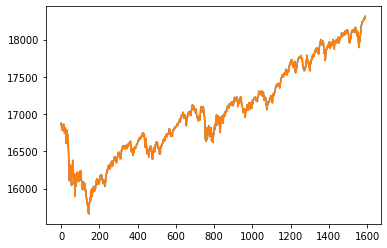

In [83]:
import matplotlib.pyplot as plt

plt.plot(tr)
plt.plot(trp)

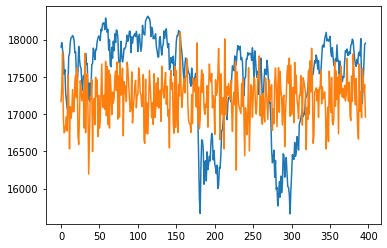

In [84]:
plt.plot(t)
plt.plot(tp)
